In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class MultiHeadFuzzyAttentionLayer(nn.Module):
    def __init__(self, input_features, output_features, initial_num_clusters, max_clusters, num_heads, input_embedding_size, threshold_distance=100):
        super(MultiHeadFuzzyAttentionLayer, self).__init__()
        
        self.embedding = nn.Linear(input_features, input_embedding_size)
        assert input_embedding_size % num_heads == 0, "Input embedding size must be divisible by the number of heads"
        self.head_dim = input_embedding_size // num_heads
        self.num_heads = num_heads
        self.threshold_distance = threshold_distance
        self.max_clusters = max_clusters

        # Initialize Fuzzy Layer parameters for each head
        self._init_fuzzy_parameters(initial_num_clusters)

        self.sm = torch.nn.Softmax(dim=2)
        self.combine_heads = nn.Linear(num_heads * self.head_dim, output_features)

        # ... [same initialization code as before] ...
        self.validation_threshold = threshold_distance

    def _add_cluster(self, z_sample, head_idx):
        if len(self.mus[head_idx]) < self.max_clusters:
            new_mu = nn.Parameter(z_sample.unsqueeze(0), requires_grad=True)
            self.mus[head_idx].append(new_mu)
            
            new_sigma_inv = torch.eye(self.head_dim).unsqueeze(0)
            new_sigma_inv = nn.Parameter(new_sigma_inv, requires_grad=True)
            self.sigma_invs[head_idx].append(new_sigma_inv)

            return len(self.mus[head_idx]) - 1
        else:
            return None
        
    def _add_cluster(self, z_sample, head_idx):
        if len(self.mus[head_idx]) < self.max_clusters:
            new_mu = nn.Parameter(z_sample.unsqueeze(0), requires_grad=True)
            self.mus[head_idx].append(new_mu)
            
            new_sigma_inv = torch.eye(self.head_dim).unsqueeze(0)
            new_sigma_inv = nn.Parameter(new_sigma_inv, requires_grad=True)
            self.sigma_invs[head_idx].append(new_sigma_inv)

            return len(self.mus[head_idx]) - 1
        else:
            return None

    def _handle_new_clusters(self, x_head, idx):
        psi, d2 = self._compute_psi(x_head, self.mus[idx][0], self.sigma_invs[idx][0])

        # Identify samples that exceed the threshold for all clusters
        exceeding_samples = (d2 > self.threshold_distance).all(dim=2).nonzero(as_tuple=True)

        # For each sample that exceeds the threshold, add a new cluster
        for b, s in zip(*exceeding_samples):
            self._add_cluster(x_head[b, s], idx)

        # Recompute distances after adding the new clusters
        psi, _ = self._compute_psi(x_head, self.mus[idx][0], self.sigma_invs[idx][0])

        return psi

    def _init_fuzzy_parameters(self, initial_num_clusters):
        self.mus = nn.ModuleList([nn.ParameterList([torch.nn.Parameter(data=10*(torch.rand(self.max_clusters, self.head_dim) - 1/2), requires_grad=True) for _ in range(initial_num_clusters)]) for _ in range(self.num_heads)])
        self.sigma_invs = nn.ModuleList([nn.ParameterList([torch.nn.Parameter(1*torch.eye(self.head_dim).repeat(self.max_clusters, 1, 1), requires_grad=True) for _ in range(initial_num_clusters)]) for _ in range(self.num_heads)])
        self.lin_fuzzies = nn.ModuleList([torch.nn.Linear(self.head_dim, self.max_clusters * self.head_dim) for _ in range(self.num_heads)])

    def _compute_psi(self, z, mu, sigma_inv):
        d = torch.sub(mu.unsqueeze(0).unsqueeze(0), z.unsqueeze(2))
        d_expanded = d.unsqueeze(-2)
        sigma_inv_expanded = sigma_inv.unsqueeze(0).unsqueeze(1)
        d2_part = d_expanded @ sigma_inv_expanded @ d.unsqueeze(-1)
        d2 = d2_part.squeeze(-1).squeeze(-1)
        
        psi = self.sm(-d2)
        return psi, d2
    
    def _process_head(self, x_head, idx):
        # Membership activations
        psi, d2 = self._compute_psi(x_head, self.mus[idx][0], self.sigma_invs[idx][0])
        
        # Handle new clusters
        exceeding_samples = (d2 > self.threshold_distance).all(dim=2).nonzero(as_tuple=True)
        for b, s in zip(*exceeding_samples):
            self._add_cluster(x_head[b, s], idx)
        psi, _ = self._compute_psi(x_head, self.mus[idx][0], self.sigma_invs[idx][0])

        # Transform input
        x_transformed = self.lin_fuzzies[idx](x_head).view(x_head.shape[0], x_head.shape[1], self.max_clusters, -1)

        # Apply attention
        return torch.einsum('btl,btlf->btf', psi, x_transformed)


    def forward(self, x):
        x = self.embedding(x)
        x_heads = torch.chunk(x, self.num_heads, dim=-1)
        outputs = [self._process_head(x_head, idx) for idx, x_head in enumerate(x_heads)]
        concatenated_output = torch.cat(outputs, dim=-1)
        return self.combine_heads(concatenated_output)

# Testing the modified version of MultiHeadFuzzyAttentionLayer with a low threshold
multi_head_attention_layer_modified = MultiHeadFuzzyAttentionLayer(input_features=5, output_features=5, initial_num_clusters=2, max_clusters=1000, num_heads=8, input_embedding_size=32, threshold_distance=0.4)
dummy_input_modified = torch.randn(100, 10, 5)
output_modified = multi_head_attention_layer_modified(dummy_input_modified)
output_modified.shape


torch.Size([100, 10, 5])

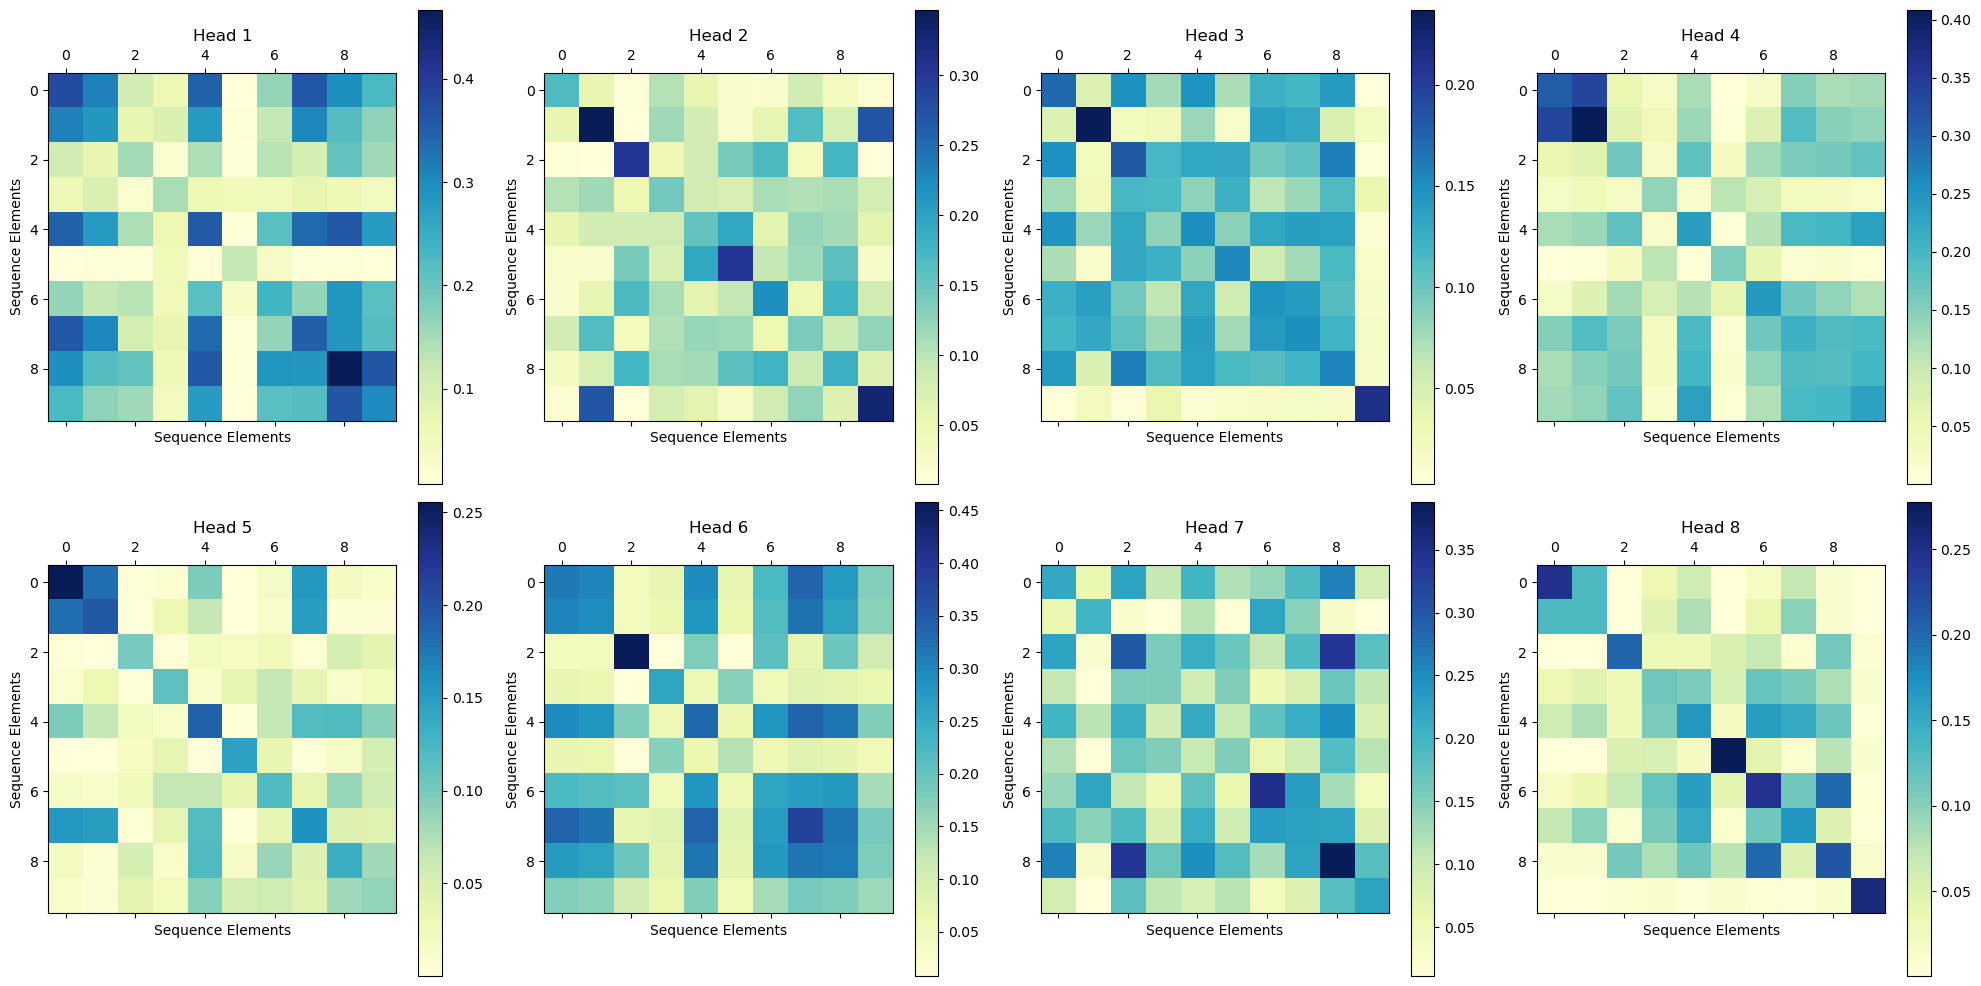

('Success', torch.Size([100, 10, 5]))

In [2]:
import matplotlib.pyplot as plt

class MultiHeadFuzzyAttentionLayerWithVisualization(MultiHeadFuzzyAttentionLayer):
    
    def visualize_attention(self, x):
        """Visualizes the self-attention based on fuzzy activations."""
        x = self.embedding(x)
        x_heads = torch.chunk(x, self.num_heads, dim=-1)

        # Define grid dimensions
        grid_rows = int(self.num_heads**0.5)
        grid_cols = int(self.num_heads / grid_rows)

        # Create a subplot for each head in a grid layout
        fig, axs = plt.subplots(grid_rows, grid_cols, figsize=(5 * grid_cols, 5 * grid_rows))
        
        for idx, x_head in enumerate(x_heads):
            psi, _ = self._compute_psi(x_head, self.mus[idx][0], self.sigma_invs[idx][0])
            similarity_matrix = torch.mm(psi[0], psi[0].t())

            row_idx = idx // grid_cols
            col_idx = idx % grid_cols

            ax = axs[row_idx, col_idx] if self.num_heads > 1 else axs

            cax = ax.matshow(similarity_matrix.detach().numpy(), cmap='YlGnBu')
            plt.colorbar(cax, ax=ax)
            ax.set_title(f"Head {idx+1}")
            ax.set_xlabel("Sequence Elements")
            ax.set_ylabel("Sequence Elements")

        plt.tight_layout()
        plt.show()

# Testing the modified version of MultiHeadFuzzyAttentionLayer with a low threshold and visualization
multi_head_attention_layer_with_visualization = MultiHeadFuzzyAttentionLayerWithVisualization(input_features=5, output_features=5, initial_num_clusters=2, max_clusters=1000, num_heads=8, input_embedding_size=32, threshold_distance=0.4)
dummy_input_modified = torch.randn(100, 10, 5)
try:
    output_modified = multi_head_attention_layer_with_visualization(dummy_input_modified)
    result_modified = "Success", output_modified.shape
except Exception as e:
    result_modified = "Error", str(e)

multi_head_attention_layer_with_visualization.visualize_attention(dummy_input_modified[:1])  # Visualizing for a single sequence for clarity
result_modified


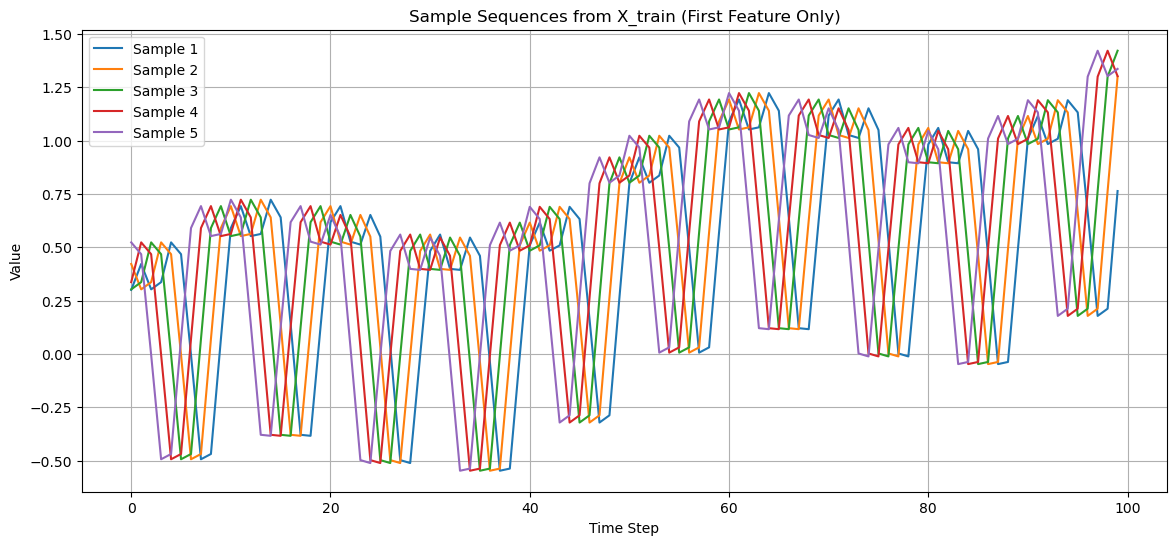

In [3]:

# Parameters and data setup
forecast_steps = 60
sequence_length = 100
num_features = 5
input_dim = 5
output_dim = 5
num_clusters_list = [1, 1, 1]
max_clusters = 10
input_embedding_size = 32
threshold_distance = 1
num_heads = 1

def create_synthetic_multivariate_time_series(timesteps, num_features, frequency=0.1, trend_slope=0.01, seasonality_frequency=0.02):
    time = np.arange(0, timesteps)
    # Create a time series with a combination of sine and cosine functions for each feature
    time_series = np.zeros((timesteps, num_features), dtype=np.float32)
    
    # Add a linear trend to each feature
    trend = trend_slope * time
    
    # Add seasonality to each feature
    for i in range(num_features):
        seasonality = 0.2 * np.sin(2 * np.pi * seasonality_frequency * time)
        time_series[:, i] = (0.5 * np.sin(2 * np.pi * frequency * time) 
                            + 0.3 * np.cos(4 * np.pi * frequency * time)
                            + trend
                            + seasonality)
    
    return torch.tensor(time_series, dtype=torch.float32)

# Create forecasting data
def create_forecasting_data(data, input_window_size, forecast_steps):
    """Segment the time series data for forecasting."""
    X = torch.stack([data[i:i+input_window_size] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    y = torch.stack([data[i+input_window_size:i+input_window_size+forecast_steps] for i in range(data.shape[0] - input_window_size - forecast_steps + 1)])
    return X, y

extended_timesteps = 300
extended_synthetic_time_series = create_synthetic_multivariate_time_series(extended_timesteps, num_features, frequency=0.1)
X_train, y_train = create_forecasting_data(extended_synthetic_time_series, sequence_length, forecast_steps)

# Plotting the first feature from a few sample sequences in X_train
plt.figure(figsize=(14, 6))

for i in range(5):
    plt.plot(range(sequence_length), X_train[i, :, 0], label=f"Sample {i+1}")

plt.title("Sample Sequences from X_train (First Feature Only)")
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [4]:
# Adjusting the final layer's input dimension based on the last layer's output

class MultiHeadForecastingNeuroFuzzyNetwork(nn.Module):
    def __init__(self, input_dim, num_clusters_list, forecast_steps, output_dim, num_heads):
        super(MultiHeadForecastingNeuroFuzzyNetwork, self).__init__()

        self.layers = nn.ModuleList()
        input_size = input_dim
        
        for num_clusters in num_clusters_list:
            layer = MultiHeadFuzzyAttentionLayer(input_features=input_size, 
                                                 output_features=output_dim, 
                                                 initial_num_clusters=num_clusters, 
                                                 max_clusters=10,  # Setting a default value for max_clusters
                                                 num_heads=num_heads, 
                                                 input_embedding_size=input_size * num_heads,
                                                 threshold_distance=100)  # Setting a default value for threshold_distance
            self.layers.append(layer)
            input_size = output_dim
        
        # Adjust the final layer to produce the correct shape based on the last layer's output
        self.final_layer = nn.Linear(sequence_length*output_dim, forecast_steps * output_dim)
        
        # Positional embeddings with adjusted size
        self.position_embedding = nn.Embedding(sequence_length, input_dim)

    def forward(self, x):
        batch_size, sequence_length, _ = x.size()
        
        # Generate position_ids based on the sequence length
        position_ids = torch.arange(sequence_length).expand((batch_size, -1)).to(x.device)
        
        # Add positional embeddings
        pos_emb = self.position_embedding(position_ids)
        x_with_position = x + pos_emb
        
        layer_output = x_with_position
        for idx, layer in enumerate(self.layers):
            layer_output = layer(layer_output)

        flattened_output = layer_output.view(batch_size, -1)
        final_output = self.final_layer(flattened_output)
        
        return final_output.view(batch_size, forecast_steps, output_dim)

# Instantiate the adjusted model
model_adjusted = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, forecast_steps, input_dim, num_heads)
model_adjusted

# Creating a dummy input for the testing
dummy_input = torch.randn(10, 100, 5)  # Batch size of 10 and input_dim of 5

# Testing with the reshaped input
try:
    output_adjusted = model_adjusted(dummy_input)
    result_adjusted = "Success", output_adjusted.shape
except Exception as e:
    result_adjusted = "Error", str(e)

result_adjusted

('Success', torch.Size([10, 60, 5]))

In [5]:

# DataLoader for training
batch_size = 513
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Loss function
loss_function = nn.MSELoss()

# Model and Optimizer
multihead_forecasting_model = MultiHeadForecastingNeuroFuzzyNetwork(input_dim, num_clusters_list, forecast_steps, input_dim, num_heads)
optimizer = torch.optim.Adam(multihead_forecasting_model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
loss_history = []

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = multihead_forecasting_model(batch_X)
        loss = loss_function(predictions, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_history.append(avg_epoch_loss)
    
    # Print every 20 epochs
    if (epoch + 1) % 1 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.4f}")



Epoch 1/300, Loss: 4.4603
Epoch 2/300, Loss: 3.9372
Epoch 3/300, Loss: 3.4487
Epoch 4/300, Loss: 2.9902
Epoch 5/300, Loss: 2.5626
Epoch 6/300, Loss: 2.1677
Epoch 7/300, Loss: 1.8081
Epoch 8/300, Loss: 1.4861
Epoch 9/300, Loss: 1.2039
Epoch 10/300, Loss: 0.9633
Epoch 11/300, Loss: 0.7658
Epoch 12/300, Loss: 0.6118
Epoch 13/300, Loss: 0.5008
Epoch 14/300, Loss: 0.4307
Epoch 15/300, Loss: 0.3979
Epoch 16/300, Loss: 0.3965
Epoch 17/300, Loss: 0.4187
Epoch 18/300, Loss: 0.4550
Epoch 19/300, Loss: 0.4954
Epoch 20/300, Loss: 0.5313
Epoch 21/300, Loss: 0.5565
Epoch 22/300, Loss: 0.5683
Epoch 23/300, Loss: 0.5665
Epoch 24/300, Loss: 0.5529
Epoch 25/300, Loss: 0.5308
Epoch 26/300, Loss: 0.5034
Epoch 27/300, Loss: 0.4741
Epoch 28/300, Loss: 0.4459
Epoch 29/300, Loss: 0.4207
Epoch 30/300, Loss: 0.4000
Epoch 31/300, Loss: 0.3843
Epoch 32/300, Loss: 0.3738
Epoch 33/300, Loss: 0.3678
Epoch 34/300, Loss: 0.3656
Epoch 35/300, Loss: 0.3662
Epoch 36/300, Loss: 0.3685
Epoch 37/300, Loss: 0.3717
Epoch 38/3

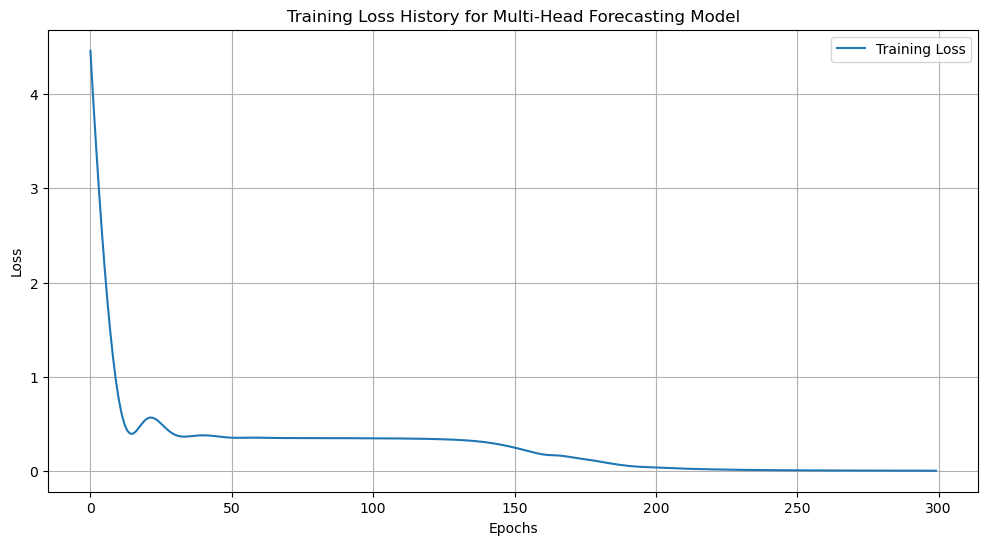

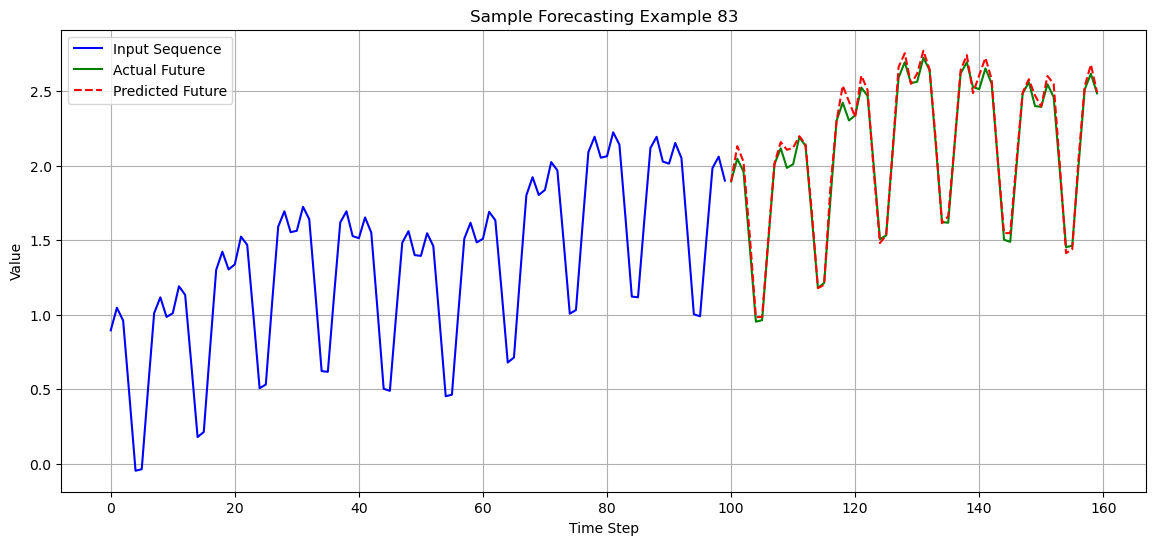

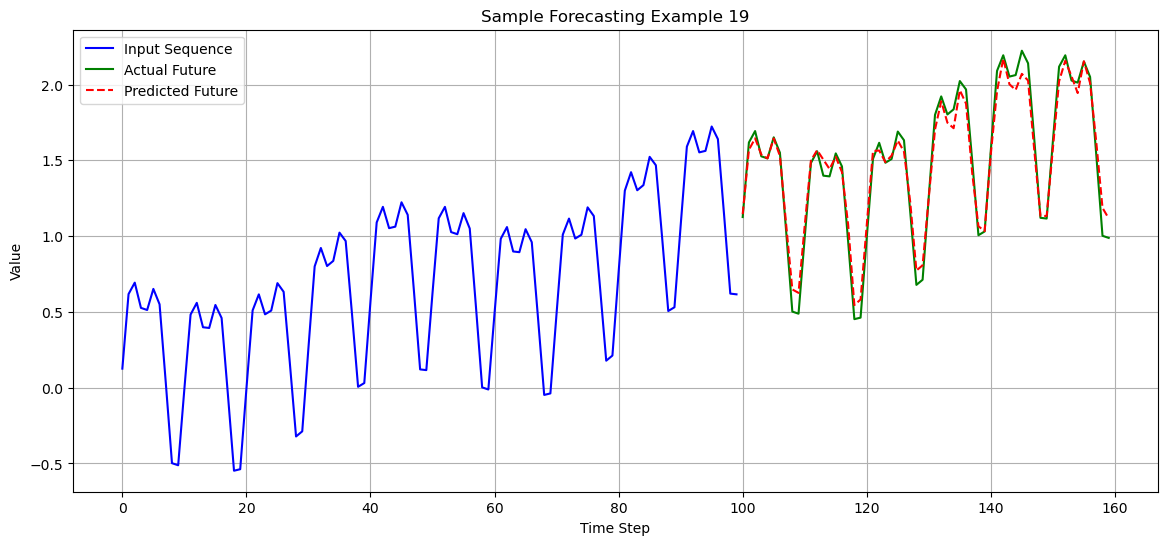

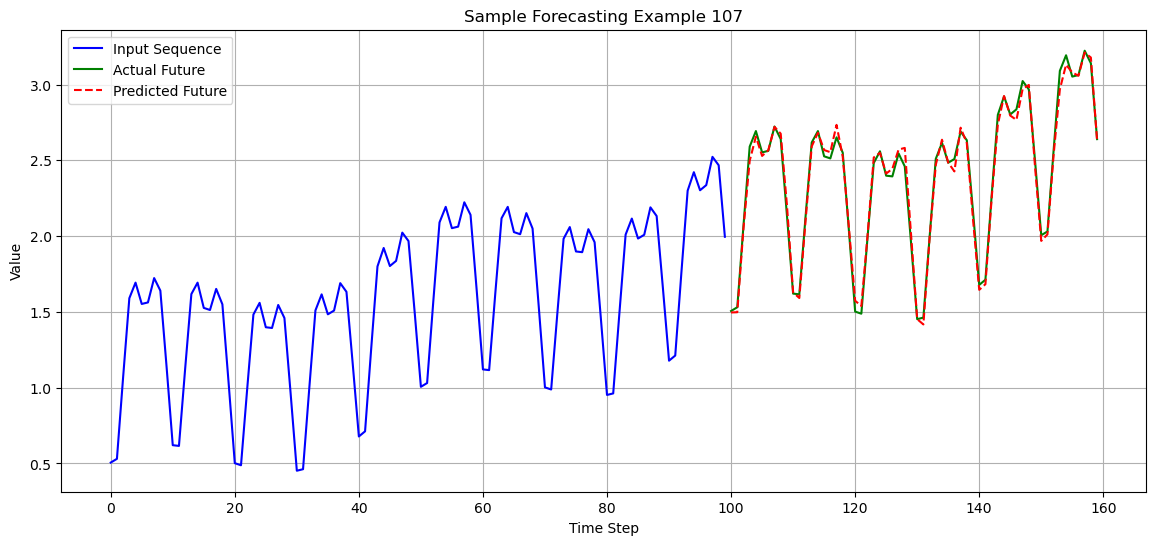

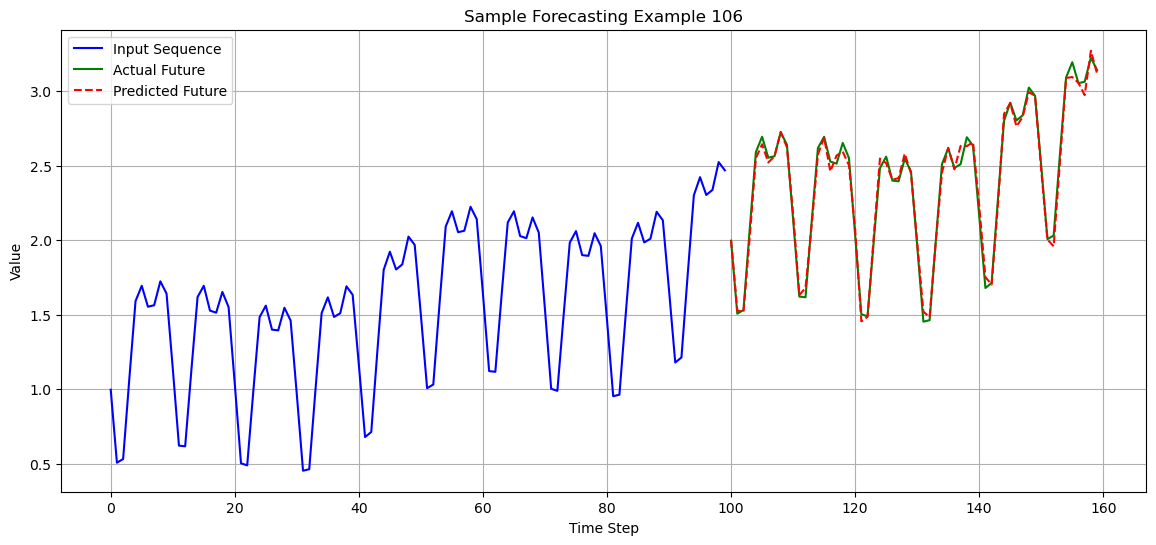

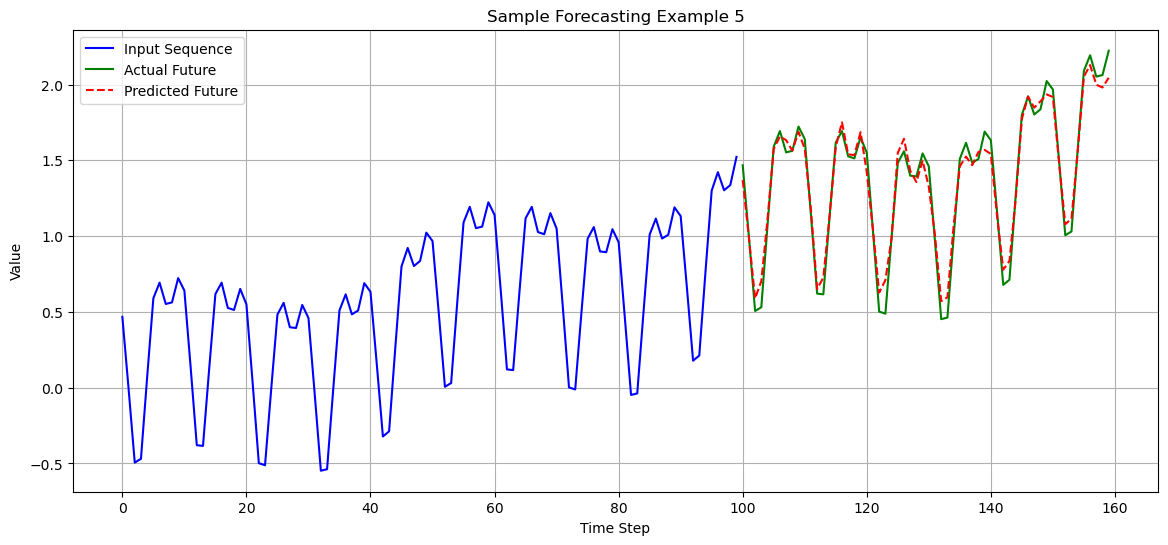

In [8]:
# Plot the training loss for the multi-head forecasting model
plt.figure(figsize=(12, 6))
plt.plot(loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss History for Multi-Head Forecasting Model")
plt.legend()
plt.grid(True)
plt.show()

multihead_forecasting_model.eval()
# Visualization of model's predictions
sample_idx = np.random.choice(len(X_train), 5, replace=False)
for idx in sample_idx:
    sample_input = X_train[idx].unsqueeze(0)
    actual_output = y_train[idx]
    predicted_output = multihead_forecasting_model(sample_input)


    
    plt.figure(figsize=(14, 6))
    plt.plot(range(sequence_length), sample_input[0, :, 0].detach().cpu(), label="Input Sequence", color="blue")
    plt.plot(range(sequence_length, sequence_length + forecast_steps), actual_output[:, 0].detach().cpu(), label="Actual Future", color="green")
    plt.plot(range(sequence_length, sequence_length + forecast_steps), predicted_output[0, :, 0].detach().cpu(), label="Predicted Future", color="red", linestyle="--")
    plt.title(f"Sample Forecasting Example {idx}")
    plt.xlabel("Time Step")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

Displaying ellipses for Layer 1


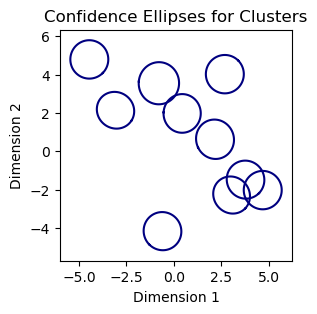

Displaying ellipses for Layer 2


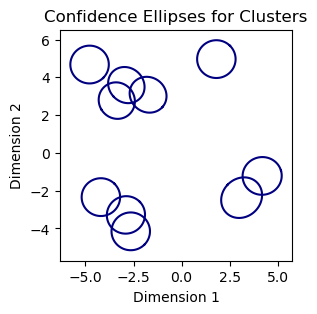

Displaying ellipses for Layer 3


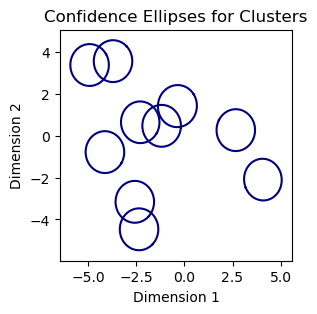

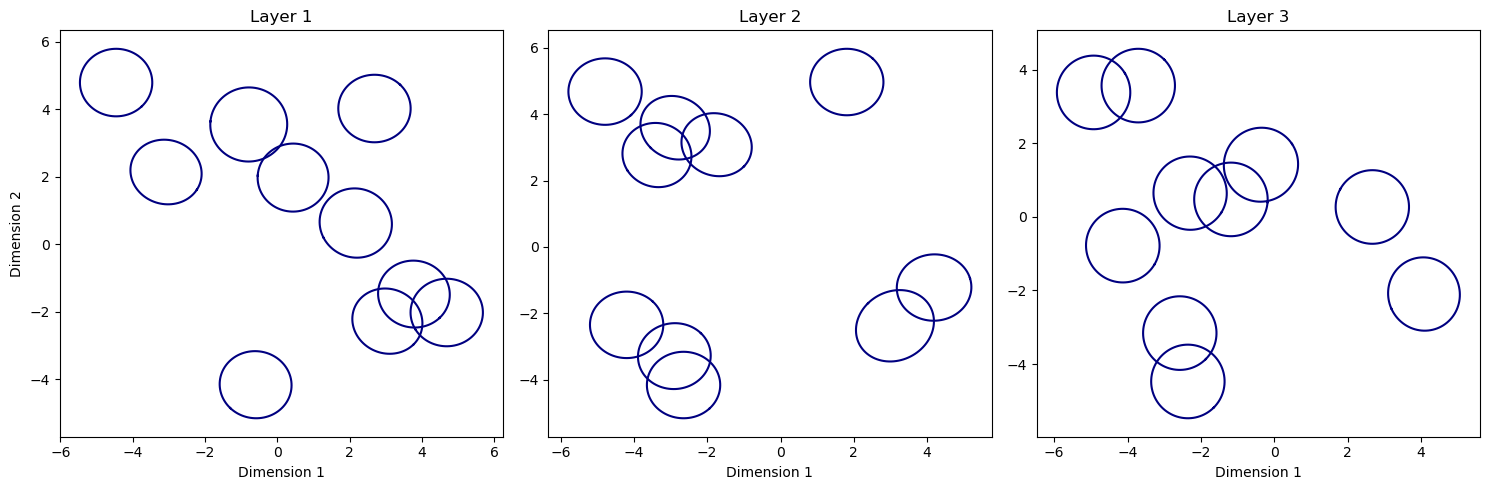

In [9]:
from numpy.linalg import inv
from numpy import linalg as LA
import numpy as np
import math

# Extract mus and sigma_invs from model_with_positional_embedding
mus_model = []
sigma_invs_model = []

# Loop through each layer and then each head's parameters
for layer in multihead_forecasting_model.layers:
    for head_mus, head_sigma_invs in zip(layer.mus, layer.sigma_invs):
        for layer_mu, layer_sigma_inv in zip(head_mus, head_sigma_invs):
            mus_model.append(layer_mu.detach().cpu().numpy())
            sigma_invs_model.append(layer_sigma_inv.detach().cpu().numpy())

mus_model[0].shape, sigma_invs_model[0].shape  # Display the shape of the first mu and sigma_inv for verification

# Adjust the Ellipse class to handle the provided shapes of mu and Sigma
class EllipseAdjusted():
    def __init__(self, Sigma, mu, n_std=1):
        self.Sigma = Sigma
        self.mu = mu
        self.n_std = n_std
        self.n_s = 100
        
    def compute_confidence_ellipse(self):
        ellipse = np.zeros((self.n_s, 2))
        w, v = LA.eig(self.Sigma)
        kot = np.linspace(0, 2 * math.pi, self.n_s, endpoint=True).reshape([-1, 1])
        rotation = np.concatenate((np.cos(kot), np.sin(kot)), axis=1)
        distance = np.matmul(np.diag(np.sqrt(w)) * self.n_std, v)
        ellipse = np.matmul(rotation, distance)
        ellipse = ellipse + self.mu
        return ellipse

# Adjust the display function to use the new EllipseAdjusted class
def display_clustering_adjusted(sigma_inv_list, mu_list):
    # Create a new figure
    fig, ax = plt.subplots(figsize=(3, 3))
    
    # Use a colormap
    color_map = plt.get_cmap('jet')
    colors = [color_map(i) for i in np.linspace(0, 1, len(mu_list))]
    
    for sigma_inv, mu, c in zip(sigma_inv_list, mu_list, colors):
        sigma = inv(sigma_inv)  # Convert sigma_inv to sigma
        for cluster_idx in range(mu.shape[0]):
            # Extract ellipses for each cluster
            ellipse_obj = EllipseAdjusted(sigma[cluster_idx], mu[cluster_idx])
            ellipse_points = ellipse_obj.compute_confidence_ellipse()
            ax.plot(ellipse_points[:, 0], ellipse_points[:, 1], color=c, label=f'Cluster {cluster_idx+1}')

    plt.title('Confidence Ellipses for Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(False)
    plt.show()

# Display the ellipses using the adjusted function
#display_clustering_adjusted([sigma_invs_model[0][:, :2, :2]], [mus_model[0][:, :2]])

# Group the mus and sigma_invs by layers
mus_by_layers = []
sigma_invs_by_layers = []

layer_size = len(multihead_forecasting_model.layers[0].mus)
for i in range(0, len(mus_model), layer_size):
    mus_by_layers.append(mus_model[i:i+layer_size])
    sigma_invs_by_layers.append(sigma_invs_model[i:i+layer_size])

# Display ellipses for each layer, focusing on the first two dimensions
for layer_idx, (mus_layer, sigma_invs_layer) in enumerate(zip(mus_by_layers, sigma_invs_by_layers)):
    print(f"Displaying ellipses for Layer {layer_idx + 1}")
    display_clustering_adjusted([sigma_inv[:, :2, :2] for sigma_inv in sigma_invs_layer], [mu[:, :2] for mu in mus_layer])
    
def plot_ellipses_in_subplot(ax, sigma_invs, mus, title):
    """Plot ellipses in a given subplot."""
    color_map = plt.get_cmap('jet')
    colors = [color_map(i) for i in np.linspace(0, 1, len(mus))]
    
    for sigma_inv, mu, c in zip(sigma_invs, mus, colors):
        # Only consider the first two dimensions for visualization
        sigma_inv_2d = sigma_inv[:, :2, :2]
        sigma_inv_reg = sigma_inv_2d + 1e-5 * np.eye(2)  # Regularize the matrix for inversion
        sigma = inv(sigma_inv_reg)
        for cluster_idx in range(mu.shape[0]):
            ellipse_obj = EllipseAdjusted(sigma[cluster_idx], mu[cluster_idx, :2])
            ellipse_points = ellipse_obj.compute_confidence_ellipse()
            ax.plot(ellipse_points[:, 0], ellipse_points[:, 1], color=c, label=f'Cluster {cluster_idx+1}')
    
    ax.set_title(title)
    ax.set_xlabel('Dimension 1')
    if title.endswith("1"):
        ax.set_ylabel('Dimension 2')
    ax.grid(False)
    
# Create a single figure with subplots
fig, axs = plt.subplots(1, len(mus_by_layers), figsize=(15, 5))

for idx, (mus_layer, sigma_invs_layer) in enumerate(zip(mus_by_layers, sigma_invs_by_layers)):
    plot_ellipses_in_subplot(axs[idx], sigma_invs_layer, mus_layer, f"Layer {idx + 1}")

plt.tight_layout()
plt.show()
